In [ ]:
'''
After trying my AlexNet implementation, which achieved 70% validation accuracy
And after trying my own custom networks, which rarely exceeded 30% validation accuracy
I decided to use the PyTorch RESNET model pretrained on ImageNet as a transfer learning
solution for the birds-400 classification problem. After 20 epochs, the network has a 90% val accuracy. 
'''

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from datetime import datetime

In [2]:
# Hyperparameters
BATCH_SIZE = 512
NUM_EPOCHS = 50
LEARNING_RATE = 0.0001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def Accuracy(output, labels):
    _, preds = torch.max(output, dim=1)
    return torch.sum(preds == labels).item() / len(preds)

In [26]:
data_dir = './birds_400'
trans = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std =[0.229, 0.224, 0.225])
])

train_ds = ImageFolder(f'{data_dir}/train', transform=trans)
test_ds  = ImageFolder(f'{data_dir}/test', transform=trans)
valid_ds = ImageFolder(f'{data_dir}/valid', transform=trans)

train_dl = DataLoader(train_ds, BATCH_SIZE, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, BATCH_SIZE, shuffle=False, num_workers=3, pin_memory=True)
test_dl  = DataLoader(test_ds, 5, shuffle=False, num_workers=3, pin_memory=True)

In [5]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)

Using cache found in C:\Users\Dan/.cache\torch\hub\pytorch_vision_v0.10.0


In [6]:
for param in model.parameters():
    param.requires_grad = False

In [7]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [8]:
model.fc = nn.Linear(in_features=512, out_features=400)

In [9]:
model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.1,
    patience=0,
    verbose=True
)

In [10]:
# training
print("Beginning training at ", datetime.now())
history = []
for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0
    for batch_idx, (images, labels) in enumerate(train_dl):
        print(f"epoch {epoch+1}: {batch_idx}/{len(train_dl)}\r", end="", flush=True)
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        pred = model(images)
        loss = loss_fn(pred, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    history.append(train_loss / (batch_idx + 1))
    print(f"Train loss: {history[-1]}", end=" ", flush=True)
    model.eval()
    with torch.no_grad():
        val_loss, val_acc = 0, 0
        for batch_idx, (images, labels) in enumerate(valid_dl):
            images, labels = images.to(device), labels.to(device)
            pred = model(images)
            loss = loss_fn(pred, labels)
            acc = Accuracy(pred, labels)
            val_loss += loss.item()
            val_acc += acc
        val_loss /= batch_idx + 1
        val_acc /= batch_idx + 1
    scheduler.step(val_acc / (batch_idx + 1))
    print(f"Val loss: {val_loss} Val Accuracy: {val_acc}", flush=True)

print(f"Validation loss: {val_loss}\nValidation Accuracy: {val_acc}")




Beginning training at  2022-03-27 17:30:59.965943
Train loss: 5.757106105141018 Val loss: 5.325234532356262 Val Accuracy: 0.09361530172413793
Train loss: 5.026408095981764 Val loss: 4.629322528839111 Val Accuracy: 0.3109341325431034
Train loss: 4.396890461963156 Val loss: 4.029539525508881 Val Accuracy: 0.47592268318965514
Train loss: 3.8469925092614217 Val loss: 3.491254210472107 Val Accuracy: 0.6066810344827587
Train loss: 3.3785310061081595 Val loss: 3.035011887550354 Val Accuracy: 0.689874057112069
Train loss: 2.9759619505509085 Val loss: 2.669651746749878 Val Accuracy: 0.7507071659482758
Train loss: 2.6397704290307087 Val loss: 2.3300949335098267 Val Accuracy: 0.7893655711206897
Train loss: 2.358997525339541 Val loss: 2.0813909769058228 Val Accuracy: 0.8116918103448276
Train loss: 2.1194625906322315 Val loss: 1.8675052523612976 Val Accuracy: 0.8271821120689655
Train loss: 1.921770655590555 Val loss: 1.6787795722484589 Val Accuracy: 0.83935546875
Train loss: 1.753416917635047 Val l

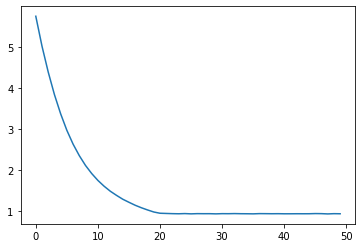

In [11]:
import matplotlib.pyplot as plt
plt.plot(history)

In [12]:
torch.save(model, 'resnet.model')

In [27]:
test_dl

In [70]:
model.eval()
loss_fn = nn.CrossEntropyLoss()
class_log_loss = {}
class_acc = []
with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_dl):
        images, labels = images.to(device), labels.to(device)
        pred = model(images)
        loss = loss_fn(pred, labels)
        class_log_loss[f'{batch_idx}'] = loss.item()
        class_acc.append(Accuracy(pred, labels))


In [71]:
len(class_log_loss)

400

In [72]:
import pandas as pd
df = pd.DataFrame.from_dict(class_log_loss, orient='index')
df['id'] = df.index
df['birds'] = df[0]
df = df.drop(0, axis=1)

In [73]:
df

,id,birds
0,0,2.757264
1,1,2.425234
2,2,0.559290
3,3,0.090832
4,4,1.994808
...,...,...
395,395,0.171569
396,396,0.255236
397,397,2.470835
398,398,0.813420


In [74]:
df.to_csv('submission.csv', index=False)